In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
season=input("Enter Season: ")

Enter Season: winter


In [4]:
file_path='/content/drive/MyDrive/CS_225/'+season+'_photos_data.csv'

In [8]:
import pandas as pd
df = pd.read_csv(file_path)
df['latitude']=df['latitude'].round(decimals=5)
df['longitude']=df['longitude'].round(decimals=5)
df_latLong= df[["latitude","longitude"]]

In [9]:
#DBSCAN Parameter Estimation (Elbow Method)
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np
coords = df_latLong.values
print(coords)
nbrs = NearestNeighbors(n_neighbors=4, algorithm='ball_tree',metric='haversine').fit(np.radians(coords))
distances, indices = nbrs.kneighbors(np.radians(coords))

[[  37.33237 -121.90063]
 [  28.37246  -81.54946]
 [  38.89765  -77.01965]
 ...
 [  48.67422 -123.68697]
 [  43.25334  -79.84806]
 [  47.24931 -122.43811]]


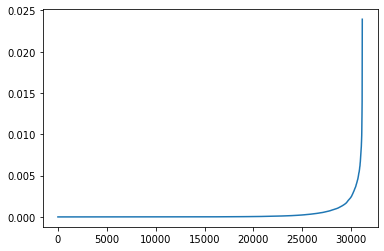

In [11]:
#Visualize elbow
distances2 = np.sort(distances, axis=0)
distances2 = distances2[:,-1]
plt.plot(distances2)

In [12]:
!pip install reverse_geocoder
!pip install geopandas

     |████████████████████████████████| 2.2 MB 7.7 MB/s 
  Created wheel for reverse-geocoder: filename=reverse_geocoder-1.5.1-py3-none-any.whl size=2268087 sha256=1fcc2921514fb3423fc93d7619a3fe52dd0e23ca8998eb033a7a14b615339155
  Stored in directory: /root/.cache/pip/wheels/34/6e/70/5423639428a2cac8ea7eb467214a4254b549b381f306a9c790
Successfully built reverse-geocoder
     |████████████████████████████████| 1.0 MB 7.1 MB/s 
     |████████████████████████████████| 15.4 MB 22.0 MB/s 
     |████████████████████████████████| 6.3 MB 21.6 MB/s 


In [13]:
#DBSCAN Algorithm Implementation

import pandas as pd, numpy as np, matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
import geopandas
import reverse_geocoder as rg
from shapely.geometry import MultiPoint,Point

coords = df_latLong.values
kms_per_radian = 6371.0088 
epsilon = 50 / kms_per_radian 
db = DBSCAN(eps=epsilon, min_samples=4, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
clusters = pd.Series([coords[cluster_labels == n] for n in range(num_clusters)])
print('Number of clusters: {}'.format(num_clusters))

Number of clusters: 70


In [14]:
#Finding each cluster's convex_hull and total number of photos
clusters=clusters[:-1]
num_clusters=len(clusters)
c_h=[]
point_column=[]
num_photos=[]
for index, value in clusters.items():
  tuples=[]
  for i in value:
    tuples.append((i[0],i[1]))
  points = MultiPoint(tuples)
  point_column.append(points)
  c_h.append(points.convex_hull)
  num_photos.append(len(value))

In [15]:
#Saving the cluster's information in a Pandas GeoDataFrame
import geopandas
gdf = geopandas.GeoDataFrame(geometry=c_h)
gdf['num_photos']=num_photos
gdf['area']=gdf.area
t_p=gdf['num_photos'].sum()
gdf['photo_factor']=gdf['num_photos'].div(t_p)
gdf

,geometry,num_photos,area,photo_factor
0,"POLYGON ((39.424 -123.819, 39.334 -123.814, 39...",12924,4.728579e+01,0.416151
1,"POLYGON ((29.147 -83.040, 27.962 -82.830, 27.6...",2340,1.267874e+01,0.075348
2,"POLYGON ((41.905 -86.609, 35.019 -85.339, 33.3...",8927,1.366819e+02,0.287448
3,"POLYGON ((48.368 -124.612, 42.844 -124.538, 40...",3104,2.527840e+01,0.099948
4,"POLYGON ((34.859 -87.541, 34.662 -86.669, 34.7...",342,3.656283e+00,0.011012
...,...,...,...,...
64,"POLYGON ((48.417 -114.352, 48.417 -114.352, 48...",4,1.350000e-09,0.000129
65,"POLYGON ((40.971 -117.737, 40.969 -117.732, 40...",4,6.274900e-06,0.000129
66,"POLYGON ((45.376 -69.431, 45.185 -69.248, 45.3...",4,9.338813e-02,0.000129
67,"POLYGON ((48.595 -118.058, 48.864 -117.371, 48...",4,7.400130e-02,0.000129


In [16]:
# Naming each cluster based on the centroid location and reverse geo-coded location
centroids=gdf.centroid
gdf['centroid']= centroids
import reverse_geocoder as rg
coords=[]
rep=[]
east=0
west=0
for index, value in centroids.items():
    coords.append((value.x,value.y))
    if value.y<-100:
      west+=1
    else:
      east+=1
    rev_geo=rg.search((value.x,value.y))
    rep.append(rev_geo[0]['name']+','+rev_geo[0]['admin1'])
gdf['cluster_name']=rep

Loading formatted geocoded file...


In [17]:
# Each User's Location History from the photos data
user_dict_initial={}
for i in range(len(df)) :
  user_name=df.loc[i,"ownername"]
  lat=df.loc[i, "latitude"]
  longg=df.loc[i, "longitude"]
  if user_name in user_dict_initial:
    user_dict_initial[user_name].append((lat,longg))
  else:
    user_dict_initial[user_name]=[(lat,longg)]

#Filter out some users based on the threshold of number of photos taken.
updated_users={}
for key in user_dict_initial:
  if len(user_dict_initial[key])>20:
    updated_users[key]=user_dict_initial[key]

user_dict={}
for i in updated_users:
  user_dict[i]=MultiPoint(updated_users[i])

# Saved User's location information in a Dataframe
user_gdf={'user_name':[],'geometry':[]}
for key in user_dict:
  user_gdf['user_name'].append(key)
  user_gdf['geometry'].append(user_dict[key])

user_df= geopandas.GeoDataFrame(user_gdf)

In [18]:
# Prepare User-Cluster Matrix for Collaborative Filtering
import numpy as np
user_mat=np.zeros((len(user_df),num_clusters))

for i in range(len(user_df)):
  user_locations=user_df.loc[i,'geometry']

  for j in range(len(gdf)):
    cluster_geom=gdf.loc[j,'geometry']
    if user_locations.intersects(cluster_geom):
      user_mat[i][j]+=1
  

In [19]:
# Matrix Factorization (MF) Based Collaborative Filtering Model

import numpy as np

class MF():

    def __init__(self, R, K, alpha, beta, iterations):
        """
        Perform matrix factorization to predict empty
        entries in a matrix.

        Arguments
        - R (ndarray)   : user-item rating matrix
        - K (int)       : number of latent dimensions
        - alpha (float) : learning rate
        - beta (float)  : regularization parameter
        """

        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations

    def train(self):
        # Initialize user and item latent feature matrice
        #self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        #self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        self.P = np.random.uniform(low=0,high=1, size=(self.num_users, self.K))
        self.Q = np.random.uniform(low=0,high=1, size=(self.num_items, self.K))

        # Initialize the biases
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)
        self.b = np.mean(self.R[np.where(self.R != 0)])

        # Create a list of training samples
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]

        # Perform stochastic gradient descent for number of iterations
        training_process = []
        iter_x=[]
        error_y=[]
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            mse = self.mse()
            training_process.append((i, mse))
            if (i+1) % 10 == 0:
                print("Iteration: %d ; error = %.4f" % (i+1, mse))
                iter_x.append(i+1)
                error_y.append(mse)

        plt.plot(iter_x, error_y )
        plt.ylabel("Mean Squared Error")
        plt.xlabel("Number of Iterations")
        plt.show()
        return training_process

    def mse(self):
        """
        A function to compute the total mean square error
        """
        xs, ys = self.R.nonzero()
        predicted = self.full_matrix()
        error = 0
        for x, y in zip(xs, ys):
            error += pow(self.R[x, y] - predicted[x, y], 2)
        return np.sqrt(error)

    def sgd(self):
        """
        Perform stochastic graident descent
        """
        for i, j, r in self.samples:
            # Computer prediction and error
            prediction = self.get_rating(i, j)
            e = (r - prediction)

            # Update biases
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i]) 
            self.b_i[j] += self.alpha * (e - self.beta * self.b_i[j])

            # Update user and item latent feature matrices
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

    def get_rating(self, i, j):
        """
        Get the predicted rating of user i and item j
        """
        prediction = self.b + self.b_u[i] + self.b_i[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    def full_matrix(self):
        """
        Computer the full matrix using the resultant biases, P and Q
        """
        return self.b + self.b_u[:,np.newaxis] + self.b_i[np.newaxis:,] + self.P.dot(self.Q.T)

Iteration: 10 ; error = 0.7283
Iteration: 20 ; error = 0.3394
Iteration: 30 ; error = 0.1976
Iteration: 40 ; error = 0.1394
Iteration: 50 ; error = 0.1029
Iteration: 60 ; error = 0.0822
Iteration: 70 ; error = 0.0678
Iteration: 80 ; error = 0.0566
Iteration: 90 ; error = 0.0469
Iteration: 100 ; error = 0.0417
Iteration: 110 ; error = 0.0377
Iteration: 120 ; error = 0.0338
Iteration: 130 ; error = 0.0306
Iteration: 140 ; error = 0.0271
Iteration: 150 ; error = 0.0253
Iteration: 160 ; error = 0.0253
Iteration: 170 ; error = 0.0230
Iteration: 180 ; error = 0.0223
Iteration: 190 ; error = 0.0212
Iteration: 200 ; error = 0.0210
Iteration: 210 ; error = 0.0200
Iteration: 220 ; error = 0.0199
Iteration: 230 ; error = 0.0195
Iteration: 240 ; error = 0.0188
Iteration: 250 ; error = 0.0186
Iteration: 260 ; error = 0.0183
Iteration: 270 ; error = 0.0181
Iteration: 280 ; error = 0.0178
Iteration: 290 ; error = 0.0172
Iteration: 300 ; error = 0.0169
Iteration: 310 ; error = 0.0166
Iteration: 320 ; 

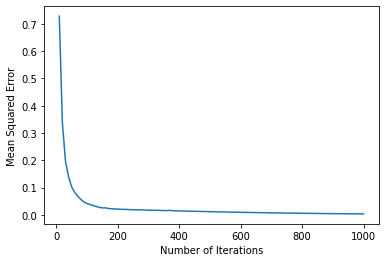

In [20]:
#Train the user-cluster matrix and Validation

mf = MF(user_mat, K=5, alpha=0.1, beta=0.01, iterations=1000)
training_process = mf.train()
pq=mf.full_matrix()
final=pd.DataFrame(pq)


In [28]:
# Processing Final Recommendation

row_no=pq.shape[0]
col_no=pq.shape[1]

for i in range(row_no):
  for j in range(col_no):
    pq[i][j]+=gdf.loc[j,'photo_factor']

lat_list=[]
long_list=[]
name_list=[]
for i in range(len(gdf)):
  cent=gdf.loc[i,'centroid']
  lat_list.append(cent.x)
  long_list.append(cent.y)
  name_list.append(gdf.loc[i,'cluster_name'])

recommend_top={'cluster_center_latitude':lat_list,'cluster_center_longitude':long_list,
               'cluster_name':name_list}


cluster_analytics={}

for i in range(row_no):
  top_ten_cluster=np.flip(np.argsort(pq[i]))[0:10]
  for key in top_ten_cluster:
    if key not in cluster_analytics:
      cluster_analytics[key]=1
    else:
      cluster_analytics[key]+=1

  l=[]
  recommend_top[user_df.loc[i,'user_name']]=[0]*len(gdf)
  for item in top_ten_cluster:
    recommend_top[user_df.loc[i,'user_name']][item]=1

    


In [22]:
recommend_df= pd.DataFrame.from_dict(recommend_top)
recommend_df

,cluster_center_latitude,cluster_center_longitude,cluster_name,earthdog,Tip - Click Albums then View Collection,anatolii.didenko,i405cmc,johnjmurphyiii,mudsharkalex,AviatorTravis,altadena_eric,jag9889,KOSAPC2,sftrajan,drum118,varnent,skapeta,Joe Shlabotnik,cseeman,bifgul,Pussreboots,Leo Tard1,lizbirdie123,skipskip,matthew valencia,Liz Henry,eb78,gunzel412,homeboy63,Chicagoan in Ohio,enst495,nbhrn_flickr,jjes84,James Fujita,myvreni,Seyemon,joeginder,ericvdb,Σταύρος,ghsheehan,...,clascaris,epc,Caleb8155 Photography,kevinrubin,mrusc96,rod1691,usf1fan2,Fruitcake Enterprises,Songdog Studios,Ron Persan,DanTappan,Joshua Robbin Marks,opedproject,Yan Lyesin,pmbell64,AGQue,AzureJay Wildlife Documentation,riptyd64,johnny neutron,cleve4952,tedeytan,Krasivaya Liza,Natasha Baucas,heytampa,buhrayin,dccradio,Random Retail,PDQuesnell,Ted Drake,benjaminfish,Rennae_lc,Chris Jepsen,Veritas Raymaker,Symbiosis,kboc923,YUHSB,onewhowaits,yunckette,litlesam1,thievingjoker
0,36.483336,-118.701812,"Three Rivers,California",0,0,0,0,0,0,1,0,1,0,1,1,1,0,1,1,1,1,1,0,0,1,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,...,0,1,0,1,1,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,1,1,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1
1,27.621663,-81.466631,"Avon Park,Florida",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
2,40.156630,-78.963947,"Jerome,Pennsylvania",0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,1,1,1,1,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,...,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,1,1,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1
3,45.392554,-122.862878,"Sherwood,Oregon",0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0
4,35.818147,-86.384473,"Murfreesboro,Tennessee",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,48.416963,-114.351990,"Whitefish,Montana",0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
65,40.970467,-117.733713,"Winnemucca,Nevada",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
66,45.399065,-69.141209,"Brownville,Maine",0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0
67,48.791827,-117.738177,"Colville,Washington",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
recommend_df.to_csv('fall_recommend.csv')

In [26]:
user_input=input("Enter User Name:")
user_index=-1
for i in range(len(user_df)):
  if user_df.loc[i,'user_name']==user_input:
    user_index=i
    break

recommended=np.flip(np.argsort(pq[user_index]))[0:10]
for idx in recommended:
  print(gdf.loc[idx,'cluster_name'])

Enter User Name:AviatorTravis
Three Rivers,California
Jerome,Pennsylvania
Sherwood,Oregon
Avon Park,Florida
Oakfield,New York
Kuna,Idaho
Menominee,Michigan
Challis,Idaho
Dentsville,South Carolina
Frisco City,Alabama


In [30]:
sort_orders = sorted(cluster_analytics.items(), key=lambda x: x[1], reverse=True)